# Machine Learning Models for Return Prediction
In this notebook, we explore various machine learning models for predicting financial returns. The models include:
- **Data Visualization**: Understanding the dataset through charts and correlation heatmaps.
- **Linear Regression**: A simple predictive model using all available features.
- **Feature Selection**: Using forward and backward selection to choose important predictors.
- **Ridge Regression**: A regularized model that penalizes large coefficients to prevent overfitting.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load dataset with two sheets: training and testing
train_data = pd.read_excel('data/Data_ret_pred.xlsx', sheet_name=0)
test_data = pd.read_excel('data/Data_ret_pred.xlsx', sheet_name=1)

# Display basic information about the training dataset
print(train_data.info())
print(train_data.describe())

c:\Users\marwi\miniconda3\envs\ml_for_finance\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yyyymm         860 non-null    int64  
 1   pd             860 non-null    float64
 2   eps            860 non-null    float64
 3   dy             860 non-null    float64
 4   b/m            860 non-null    float64
 5   tbl            860 non-null    float64
 6   CreditSpread   860 non-null    float64
 7   DefaultSpread  860 non-null    float64
 8   lty            860 non-null    float64
 9   ntis           860 non-null    float64
 10  infl           860 non-null    float64
 11  ltr            860 non-null    float64
 12  corpr          860 non-null    float64
 13  svar           860 non-null    float64
 14  ExReturns      860 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 100.9 KB
None
              yyyymm          pd         eps          dy         b/m  \
count     860.000

## Data Visualization
We start by visualizing the dataset to understand the distribution of features and correlations between them.

<Figure size 1200x600 with 0 Axes>

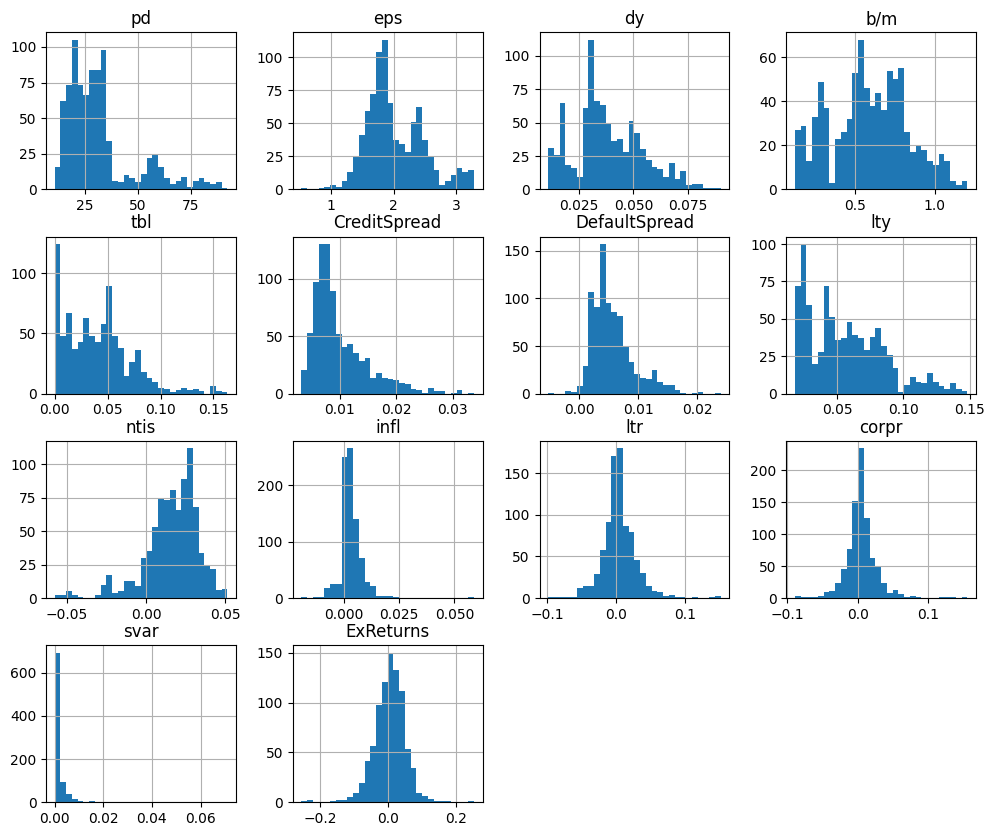

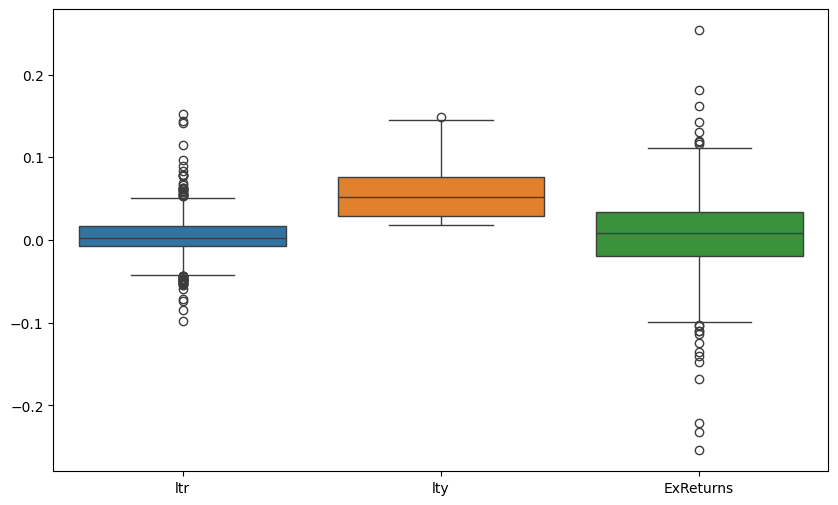

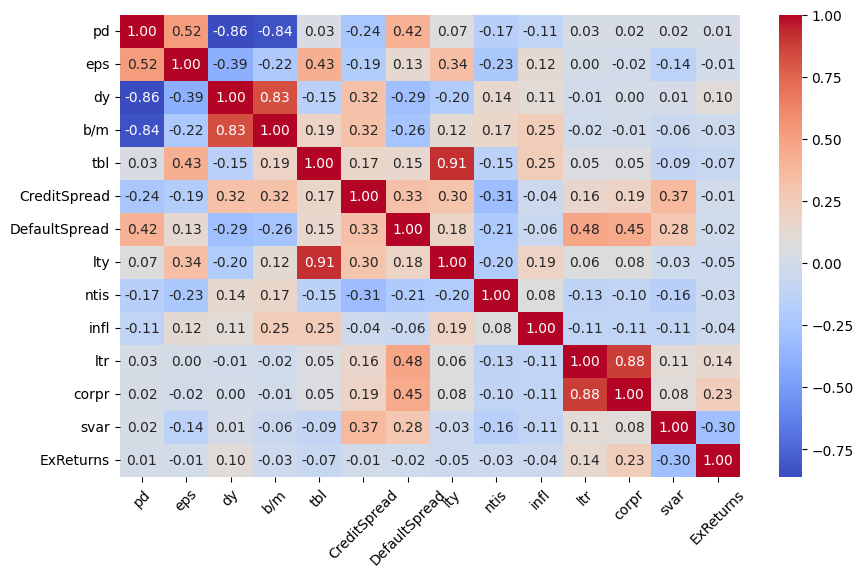

In [3]:
# Visualization using train data
plt.figure(figsize=(12, 6))
train_data.iloc[:,1:].hist(bins=30, figsize=(12, 10))
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data[['ltr', 'lty', 'ExReturns' ]])
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(train_data.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.show()

## Simple Regression Model
A basic linear regression model is used to predict returns using all available predictors.

In [4]:
# Define predictors and target
X_train = train_data.drop(columns=['ExReturns', 'yyyymm'])
X_test = test_data.drop(columns=['ExReturns', 'yyyymm'])
y_train = train_data['ExReturns']
y_test = test_data['ExReturns']

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simple Regression Model
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

Linear Regression MSE: 0.0014949378950819157


## Feature Selection
We apply forward and backward feature selection methods to choose important predictors.

## Sequential Feature Selector
Sequential Feature Selection (SFS) is a greedy procedure used to select a subset of features that optimize a given criterion.

### Procedure:
1. **Forward Selection:**
    - Starts with an empty set of features.
    - Iteratively adds the feature that results in the best model performance.
    - Continues until the stopping criterion is met.

2. **Backward Selection:**
    - Starts with all features included.
    - Iteratively removes the least important feature.
    - Continues until the stopping criterion is met.

### Selection Criterion:
- The feature selection process evaluates each subset using a performance metric, commonly **Mean Squared Error (MSE)** for regression problems.
- The feature that contributes the most to minimizing the error is chosen in forward selection.
- In backward selection, the feature that contributes the least is removed first.

### Stopping Rule:
- A predefined number of features is reached.
- Adding/removing features does not improve model performance significantly.
- The cross-validation score does not improve further.


Selected features (Forward Selection): Index(['dy', 'tbl', 'lty', 'ntis', 'corpr', 'svar'], dtype='object')
Selected features (Backward Selection): Index(['eps', 'tbl', 'lty', 'ntis', 'ltr', 'corpr', 'svar'], dtype='object')
MSE (OLS Model): 0.001495
MSE (SFS Forward Selection): 0.001525
MSE (SFS Backward Selection): 0.001434


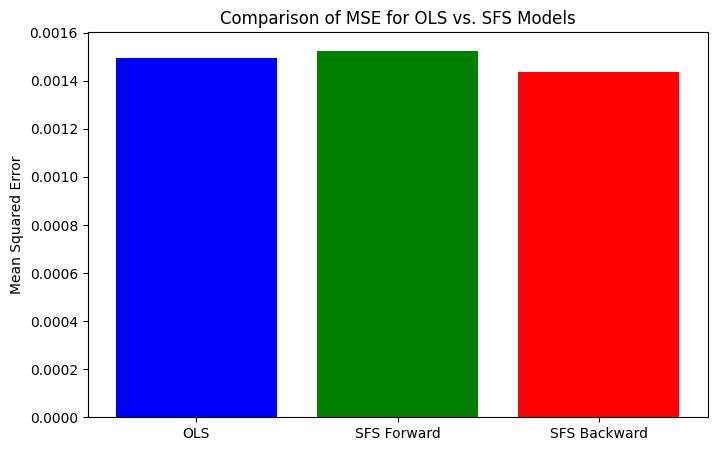

In [5]:
# Feature Selection
sfs_forward = SequentialFeatureSelector(LinearRegression(), direction='forward').fit(X_train_scaled, y_train)
sfs_backward = SequentialFeatureSelector(LinearRegression(), direction='backward').fit(X_train_scaled, y_train)

selected_features_forward = X_train.columns[sfs_forward.support_]
selected_features_backward = X_train.columns[sfs_backward.support_]

print('Selected features (Forward Selection):', selected_features_forward)
print('Selected features (Backward Selection):', selected_features_backward)

# Evaluate Sequential Feature Selector (SFS) model on test data
# Subset test data with selected features
X_train_selected_fwd = X_train[selected_features_forward]
X_test_selected_fwd = X_test[selected_features_forward]

X_train_selected_bwd = X_train[selected_features_backward]
X_test_selected_bwd = X_test[selected_features_backward]

# Train models using selected features
reg_fwd = LinearRegression()
reg_fwd.fit(X_train_selected_fwd, y_train)
y_pred_fwd = reg_fwd.predict(X_test_selected_fwd)
mse_fwd = mean_squared_error(y_test, y_pred_fwd)

reg_bwd = LinearRegression()
reg_bwd.fit(X_train_selected_bwd, y_train)
y_pred_bwd = reg_bwd.predict(X_test_selected_bwd)
mse_bwd = mean_squared_error(y_test, y_pred_bwd)

# Compare with original OLS model
mse_ols = mean_squared_error(y_test, y_pred)

print(f'MSE (OLS Model): {mse_ols:.6f}')
print(f'MSE (SFS Forward Selection): {mse_fwd:.6f}')
print(f'MSE (SFS Backward Selection): {mse_bwd:.6f}')

# Visualization of MSE Comparison
plt.figure(figsize=(8, 5))
models = ['OLS', 'SFS Forward', 'SFS Backward']
mse_values = [mse_ols, mse_fwd, mse_bwd]

plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.ylabel("Mean Squared Error")
plt.title("Comparison of MSE for OLS vs. SFS Models")
plt.show()


## Ridge Regression

Ridge Regression is a **regularized** version of linear regression that adds an **L2 penalty** (sum of squared coefficients) to the loss function to reduce overfitting. The optimization problem for Ridge Regression is:

$$
\min_{w} \sum_{i=1}^{n} (y_i - X_i w)^2 + \alpha \sum_{j=1}^{p} w_j^2
$$

where:
- $y_i$ are the actual target values,
- $X_i$ are the predictor values,
- $w$ are the model coefficients,
- $\alpha$ is the **regularization parameter** (also called the shrinkage parameter).

### Why Use Ridge Regression?
- Helps when there is **multicollinearity** among features. Helps to alleviate the issues related to **multicollinearity**.
- Reduces model variance by shrinking coefficients towards zero.
- Achieve better MSE than unbiased linear models.

### Effect of the Shrinkage Parameter $\alpha$
- **Small $\alpha$**: Ridge behaves like ordinary least squares regression.
- **Large $\alpha$**: More shrinkage is applied, reducing coefficient magnitude and increasing bias.

---

## Bias-Variance Trade-off

The **Bias-Variance Trade-off** is a fundamental concept in machine learning that explains the balance between model complexity and generalization.

- **Bias**: The error introduced by approximating a real-world problem with a simplified model.
  - High bias means the model is too simple and underfits the data.
  
- **Variance**: The error due to the model’s sensitivity to fluctuations in the training data.
  - High variance means the model is too complex and overfits the training data.

**Ridge regression helps balance this trade-off by introducing regularization:**
- It slightly increases **bias** by shrinking coefficients.
- It significantly reduces **variance**, leading to better generalization.

### Bias-Variance Relationship in Ridge Regression
- **Small $\alpha$** → lower bias, higher variance.
- **Large $\alpha$** → higher bias, lower variance.
- The goal is to **find an optimal $\alpha$** that minimizes the total MSE.

---

### Visualization Idea
You can plot **train and test errors** against **alpha values** to observe the bias-variance trade-off (see lecture notes):

$$
\text{MSE} = \text{Bias}^2 + \text{Variance} 
$$

This allows us to select the **best $\alpha$** for Ridge Regression.

---


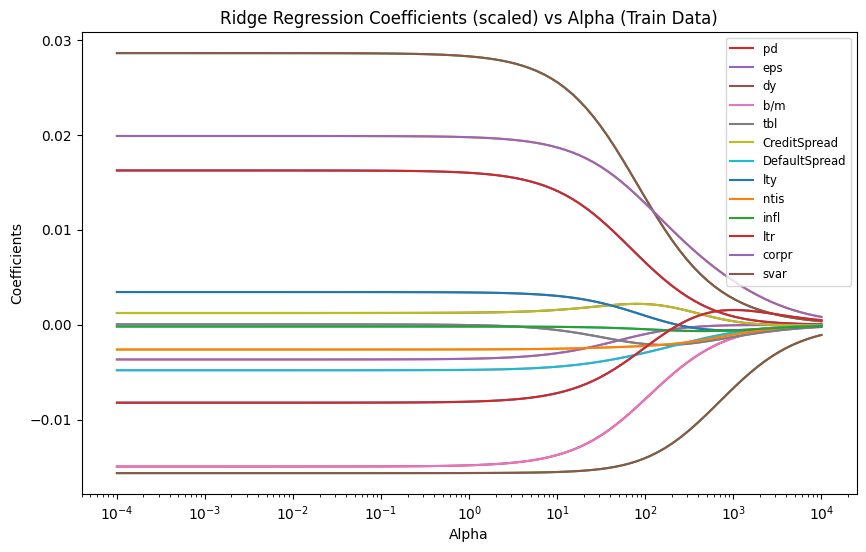

Optimal alpha: 0.015199
MSE for Ridge: 0.001359


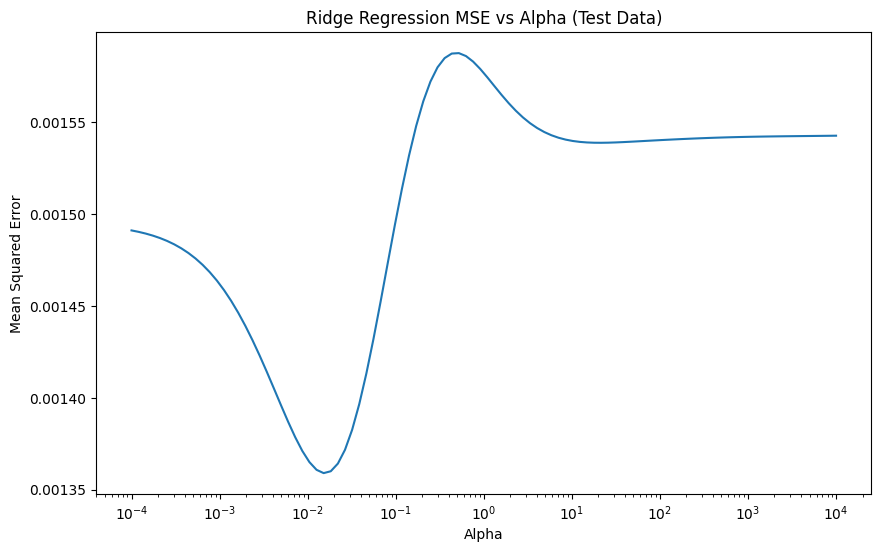

In [6]:
# Ridge Regression
alphas = np.logspace(-4, 4, 100)
coefs = []
errors = []

# Use train data to plot the lambda/coefficient graph
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

# Convert to NumPy array for plotting
coefs = np.array(coefs)

# Plot Ridge Coefficients vs lambda using train data
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
# Add a legend for each coefficient
for idx, coef in enumerate(coefs.T):  # Transpose to iterate over each coefficient
    plt.plot(alphas, coef, label=f'{X_train.columns[idx]}')
plt.legend(loc='best', fontsize='small', frameon=True)  # Add legend
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Coefficients (scaled) vs Alpha (Train Data)')
plt.show()

# Use testing data to choose optimal alpha
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    errors.append(mean_squared_error(y_test, y_pred_ridge))

# Convert to NumPy array for plotting
errors = np.array(errors)

# Find the optimal alpha
optimal_alpha = alphas[np.argmin(errors)]
print(f'Optimal alpha: {optimal_alpha:.6f}')
print(f'MSE for Ridge: {np.min(errors):.6f}')

# Plot MSE vs alpha using testing data
plt.figure(figsize=(10, 6))
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression MSE vs Alpha (Test Data)')
plt.show()

# What is Cross-Validation (CV) and why do we need CV?
  - In real-life scenarios, training/testing datasets are not given and we need to determine how to split the training and testing samples. The way to split is not unique. 
  - **Cross-validation** is a **resampling technique** used to assess model performance and select hyperparameters (like alpha in Ridge Regression) more effectively. Instead of using a single training-validation split, we use multiple splits to obtain a more reliable estimate of model performance.
  - When we use regularization techniques like Ridge Regression, which introduces a penalty term controlled by alpha (λ). But how do we determine the best alpha? This is where Cross-Validation (CV) helps! 
  - The most commonly used cross-validation method is **K-Fold Cross-Validation**. *Watch out how is this different from the exercise from above?*

1. Split the training data into K subsets (folds).

2. Train the model on K-1 folds and validate it on the remaining fold.

3. Repeat this K times, using a different fold for validation each time.

4. Compute the average validation error across all K folds.

5. Select the hyperparameter (alpha) that minimizes the error.

In [5]:
# Let's use the training sample to perform cross-validation (CV) suppose we don't have a separate testing sample.
# Find the optimal tuning parameter for a Ridge regression model.
# Note that in many empirical datasets, the training and testing samples are not pre-divided for you.
# It is up to the analyst's discretion to determine how to split them.

from sklearn.linear_model import RidgeCV

# Define a range of alpha values to search
alphas = np.logspace(-5, 5, 100)  # From 10^-5 to 10^5

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=alphas, cv=10)  # Uses built-in CV
ridge_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = ridge_cv.alpha_
print(f"Optimal alpha (λ) selected: {best_alpha:.5f}")





Optimal alpha (λ) selected: 0.00673
